# How to use the FairFL-Data framework

Overall, this framework can be used to generate data for fair Federated Learning settings and Federated Learning settings in general. The data is non-synthetic but based on the ACSIncome and ACSEmployment dataset. It is evaluated with regard to fairness metrics during the generation. As our implementation is based on Flower Datasets Module, we recommend to read the documentation at https://flower.ai/docs/datasets/index.html.


## 1. Generating a FairFL Dataset

To generate a dataset and its partitions, you need to specify the name of the dataset (ACSIncome/ACSEmployment) and the states you want to load. The states are internally stored as "splits". For each state it is additionally required to specify a partitioner if this state should be considered for the internal evaluations. If no states and no partitioner are specified this defaults to lading all states as a single partition. For using partitioners, we refer to https://flower.ai/docs/datasets/tutorial-use-partitioners.html.

In this example, we apply the default IIDPartitioner which is initialized internally by simply giving a number of desired partitions per state.


Creating CSV from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

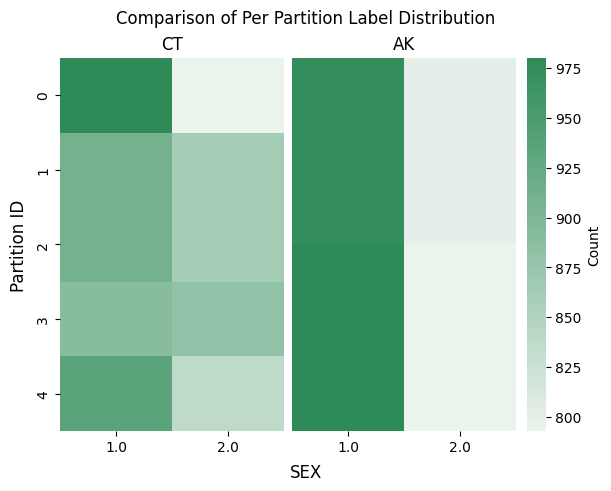

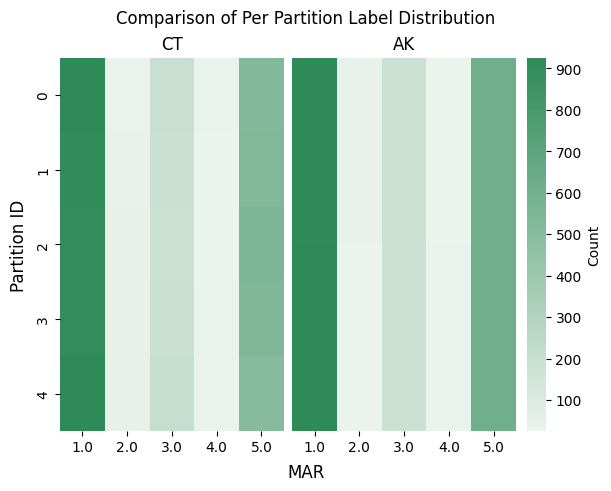

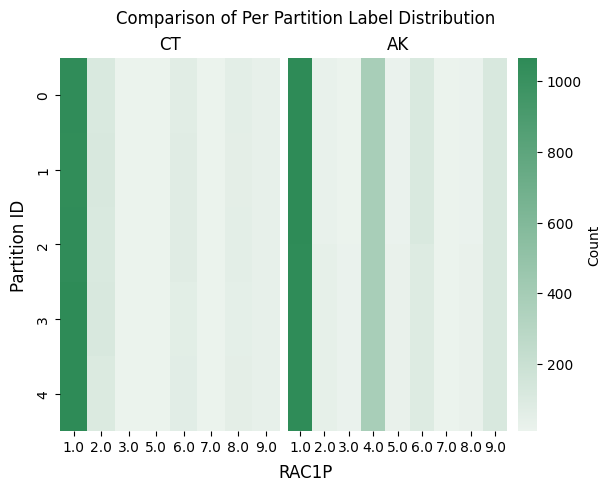

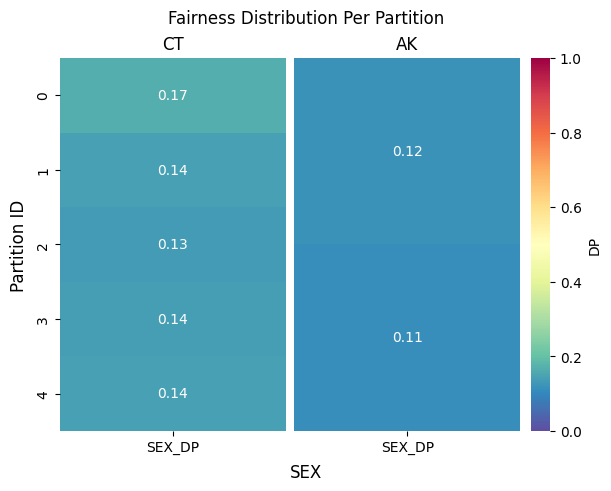

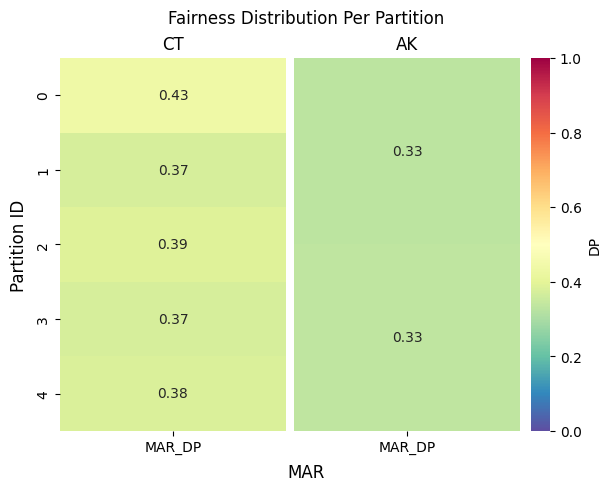

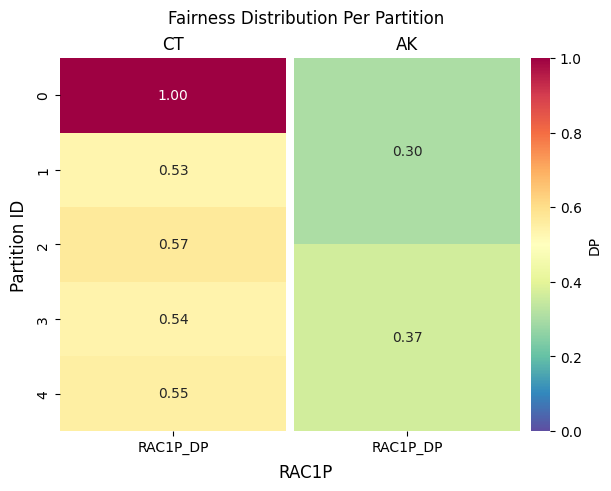

In [9]:
from FairFederatedDataset import FairFederatedDataset
import warnings

warnings.filterwarnings("ignore")

# specify the FL dataset, sets 5 partitions for CT and 2 for AK
ffds = FairFederatedDataset(
    dataset="ACSIncome",
    states=["CT", "AK"],
    partitioners={"CT": 5, "AK": 2},
    fl_setting=None,
    fairness_metric="DP",
    fairness_level="attribute",
)

# Calling one of the following additionally returns evaluation for the complete dataset, as only then data is downloaded
# load the first partition of CT
partition_CT_0 = ffds.load_partition(split="CT", partition_id=0)

# load the complete state CT
split_CT = ffds.load_split("CT")

# the data can be stored with
ffds.save_dataset("data")

# 2. Generate a Modified FairFL Dataset

To generate a modified dataset, you can use the `FairFLDataset` class and specify a modification dict in which we describe the modifications we want to apply (e.g., label_name flipping, dropping datapoints) to specific states, (e.g. { "CT": { "MAR": { "drop_rate": 0.2, "flip_rate": 0.1, "value": 2, "attribute": "SEX", "attribute_value": 2, }, "SEX": { "drop_rate": 0.3, "flip_rate": 0.2, "value": 2, "attribute": None, "attribute_value": None, }, }}).


Creating CSV from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

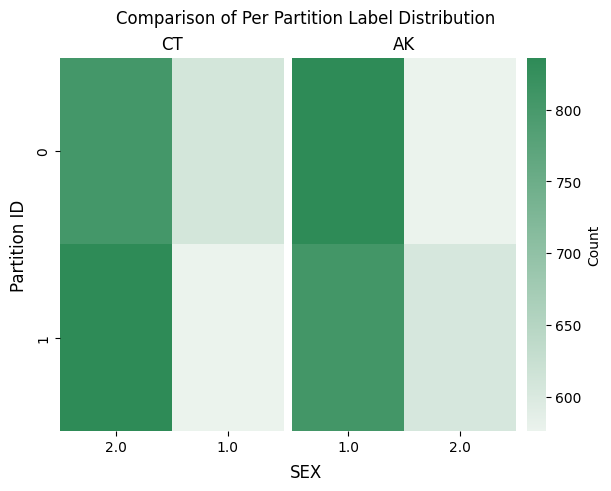

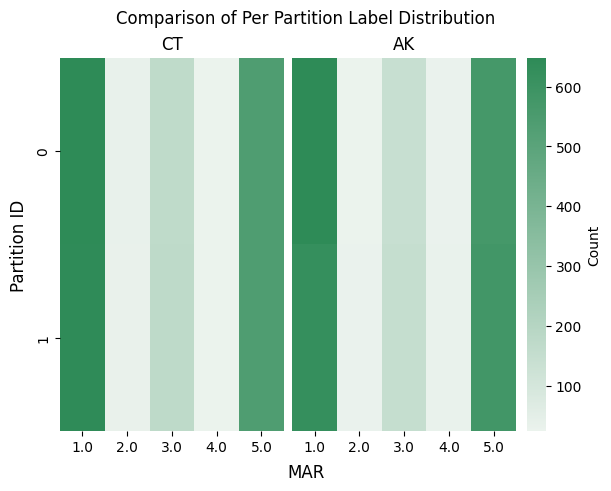

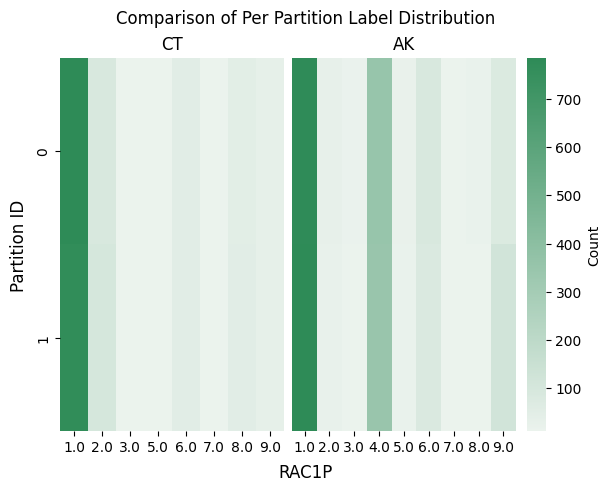

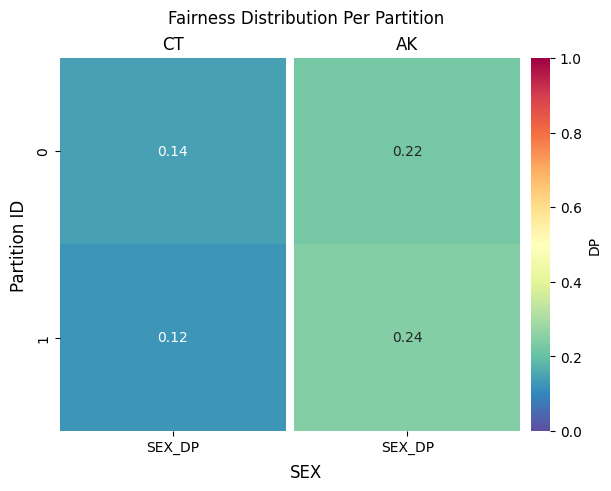

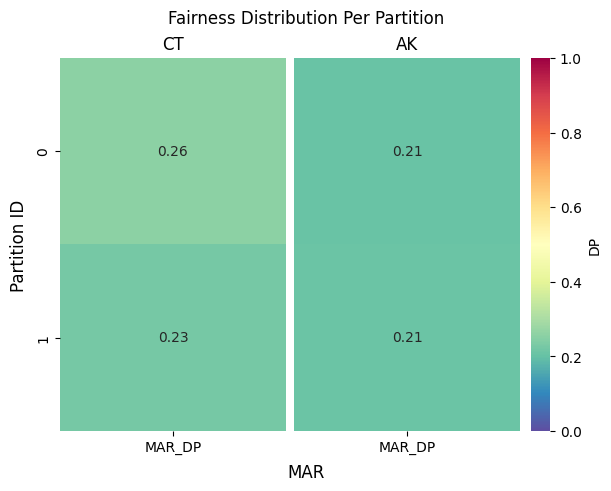

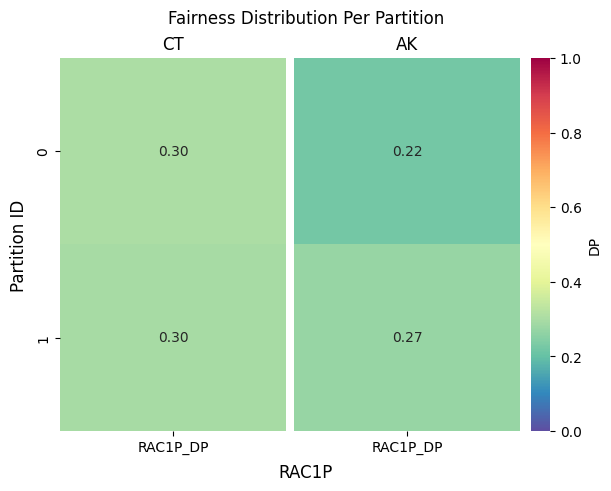

In [10]:
# specify the FL dataset, sets 5 partitions for CT and 2 for AK
ffds = FairFederatedDataset(
    dataset="ACSIncome",
    states=["CT", "AK"],
    partitioners={"CT": 2, "AK": 2},
    fl_setting=None,
    fairness_metric="DP",
    fairness_level="attribute",
    modification_dict={
        "CT": {
            "MAR": {
                "drop_rate": 0.6,
                "flip_rate": 0.3,
                "value": 1,
                "attribute": "SEX",
                "attribute_value": 1,
            },
            "SEX": {
                "drop_rate": 0.5,
                "flip_rate": 0.2,
                "value": 2,
                "attribute": None,
                "attribute_value": None,
            },
        },
        "AK": {
            "MAR": {
                "drop_rate": 0.5,
                "flip_rate": 0.2,
                "value": 1,
                "attribute": "SEX",
                "attribute_value": 1,
            },
            "SEX": {
                "drop_rate": 0.8,
                "flip_rate": 0.3,
                "value": 2,
                "attribute": None,
                "attribute_value": None,
            },
        }
    },
)

# Calling one of the following additionally returns evaluation for the complete dataset, as only then data is downloaded
# load the first partition of CT
partition_CT_0 = ffds.load_partition(split="CT", partition_id=0)

# load the complete state CT
split_CT = ffds.load_split("CT")

# the data can be stored with
ffds.save_dataset("data")

# 4. Training local models on the generated dataset

We train a simple Logistic regression model on the generated dataset. Then, we evaluate the accuracy and the unfairness of the local models.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from fairness_computation import _compute_fairness
import pandas as pd

states = ["CT", "AK"]
partitions = [0, 1]
for state in states:
    for partition in partitions:
        dataset = ffds.load_partition(split=state, partition_id=partition)
        train, test = train_test_split(dataset.to_pandas(), test_size=0.2, random_state=42)
        # train a simple logistic regression model
        model = LogisticRegression()
        model.fit(train.drop(columns=["PINCP"]), train["PINCP"])
        # evaluate the model on the test set
        accuracy = model.score(test.drop(columns=["PINCP"]), test["PINCP"])
        print(f"Accuracy on {state} partition {partition}: {accuracy}")

        y_test = test["PINCP"]
        preds = model.predict(test.drop(columns=["PINCP"]))
        fairness_metric = "DP"
        fairness_level = "attribute"
        sens_att = "SEX"
        sf_data = pd.DataFrame(
            {
                "SEX": [int(item) for item in test["SEX"]],
            }
        )
        unfairness = _compute_fairness(
            y_true=y_test, y_pred=preds, sf_data=sf_data, fairness_metric=fairness_metric, sens_att=sens_att, size_unit=fairness_level
        )
        print(f"Unfairness for {state}, partition {partition}, sensitive attribute {sens_att}: {unfairness[0]}")
        print("-" * 50)

Accuracy on CT partition 0: 0.7457627118644068
Unfairness for CT, partition 0, sensitive attribute SEX: 0.08251060704960836
--------------------------------------------------
Accuracy on CT partition 1: 0.7646675358539765
Unfairness for CT, partition 1, sensitive attribute SEX: 0.047588555858310636
--------------------------------------------------
Accuracy on AK partition 0: 0.8197879858657244
Unfairness for AK, partition 0, sensitive attribute SEX: 0.036585365853658534
--------------------------------------------------
Accuracy on AK partition 1: 0.7915194346289752
Unfairness for AK, partition 1, sensitive attribute SEX: 0.0748660398341927
--------------------------------------------------


# 5. Training a Federated Learning model

### Prepare Dataset for Federated Learning training 

In [12]:
from example_utils import pre_process_dataset_for_FL

states = ["CT", "AK"]
ids = [0, 1]
pre_process_dataset_for_FL(states=states, ids=ids, ffds=ffds)

### Train a Federated Learning model

In [13]:
from example_utils import LinearClassificationNet, train, test, get_params, set_params, weighted_average
from typing import Dict, Tuple

import torch
from flwr.common import NDArrays, Scalar
from flwr.client import NumPyClient

from flwr.common import Context
from flwr.client import ClientApp


from flwr.common import ndarrays_to_parameters
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from torch.utils.data import DataLoader

from pathlib import Path


class FlowerClient(NumPyClient):
    def __init__(self, trainloader, valloader) -> None:
        super().__init__()

        self.trainloader = trainloader
        self.valloader = valloader
        self.model = LinearClassificationNet(input_size=42, output_size=2)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def fit(self, parameters, config):
        """This method trains the model using the parameters sent by the
        server on the dataset of this client. At then end, the parameters
        of the locally trained model are communicated back to the server"""

        # copy parameters sent by the server into client's local model
        set_params(self.model, parameters)

        # Define the optimizer
        optim = torch.optim.SGD(self.model.parameters(), lr=0.01)

        # do local training (call same function as centralised setting)
        train(self.model, self.trainloader, optim, self.device)

        # return the model parameters to the server as well as extra info (number of training examples in this case)
        return get_params(self.model), len(self.trainloader), {}

    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):
        """Evaluate the model sent by the server on this client's
        local validation set. Then return performance metrics."""

        set_params(self.model, parameters)
        # do local evaluation (call same function as centralised setting)
        loss, accuracy, fairness_dict = test(self.model, self.valloader, self.device)
        for key, value in fairness_dict.items():
            print("Unfairness for {}: {}".format(key, value[0]))
        # send the loss and accuracy back to the server
        # send statistics back to the server
        return float(loss), len(self.valloader), {"accuracy": accuracy}

In [14]:
def client_fn(context: Context):
    """Returns a FlowerClient containing its data partition."""

    partition_id = int(context.node_config["partition-id"])

    train = torch.load(Path(f"./data/federated/{partition_id}/train.pt"))
    test = torch.load(Path(f"./data/federated/{partition_id}/test.pt"))
    kwargs = {"num_workers": 5, "pin_memory": True, "drop_last": False}
    trainloader = DataLoader(train, batch_size=2048, **kwargs)
    testloader = DataLoader(test, batch_size=2048, **kwargs)

    return FlowerClient(trainloader=trainloader, valloader=testloader).to_client()


# Concstruct the ClientApp passing the client generation function
client_app = ClientApp(client_fn=client_fn)

In [15]:
num_rounds = 5


def server_fn(context: Context):
    # instantiate the model
    model = LinearClassificationNet(input_size=42, output_size=2)
    ndarrays = get_params(model)
    # Convert model parameters to flwr.common.Parameters
    global_model_init = ndarrays_to_parameters(ndarrays)

    # Define the strategy
    strategy = FedAvg(
        fraction_fit=1.0,  # All clients participate in training
        fraction_evaluate=1.0,  # All clients participate in evaluation
        evaluate_metrics_aggregation_fn=weighted_average,  # callback defined earlier
        initial_parameters=global_model_init,  # initialised global model
    )

    # Construct ServerConfig
    config = ServerConfig(num_rounds=num_rounds)

    # Wrap everything into a `ServerAppComponents` object
    return ServerAppComponents(strategy=strategy, config=config)


# Create your ServerApp
server_app = ServerApp(server_fn=server_fn)

In [16]:
run_simulation(server_app=server_app, client_app=client_app, num_supernodes=4)

INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)
(ClientAppActor pid=1688662) /tmp/ipykernel_1623960/2707283136.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed 

(ClientAppActor pid=1688666) Unfairness for MAR_DP: 0.0
(ClientAppActor pid=1688666) Unfairness for SEX_DP: 0.0
(ClientAppActor pid=1688666) Unfairness for MAR_EO: 0.0
(ClientAppActor pid=1688666) Unfairness for SEX_EO: 0.0


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      configure_evaluate: strategy sampled 4 clients (out of 4)
INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)
INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      configure_evaluate: strategy sampled 4 clients (out of 4)
INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)
INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      configure_evaluate: strategy sampled 4 clients (out of 4)
INFO :      aggregate_evaluate: received 4 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)
INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      configure_evaluate: strategy sampled

(ClientAppActor pid=1688656) Unfairness for MAR_DP: 0.015625 [repeated 19x across cluster]
(ClientAppActor pid=1688656) Unfairness for SEX_DP: 0.015625 [repeated 19x across cluster]
(ClientAppActor pid=1688656) Unfairness for MAR_EO: 0.016129032258064516 [repeated 19x across cluster]
(ClientAppActor pid=1688656) Unfairness for SEX_EO: 0.016129032258064516 [repeated 19x across cluster]
